# Landmark Classification and Tagging using CNN

## Project Requirements

## Dataset
Dataset can be downloaded from [here](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip)

In [ ]:
# custom lib
HAS_GPU = 0

if HAS_GPU:
    !pip install mxnet-cu80
else:
    !pip install mxnet

In [2]:
# imports

## stdlib
from datetime import datetime
from os import mkdir
from os.path import exists

## numerical lib
import numpy as np

## deep learing lib
import mxnet as mx
from mxnet import nd, gluon, autograd, init
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms

## plotting lib
import matplotlib.pyplot as plt

In [3]:
# setup context
gpu_count = mx.context.num_gpus()
ctx = mx.gpu(0) if (gpu_count > 0) else mx.cpu()
print("using context: ", ctx)

using context:  cpu(0)


## Load Data and Setup Data Iterators

In [4]:
# global constants
DATASET_FOLDER = "landmark_images"
TRAIN_FOLDER   = f"{DATASET_FOLDER}/train"
TEST_FOLDER    = f"{DATASET_FOLDER}/test"

INPUT_IMAGE_W_H   = (256, 256)
N_OUTPUT_CLASSES  = 50

In [5]:
# transformations that should be used for Batch Augmentation
BATCH_AUGMENTATION_TRANSFORMATIONS = [transforms.RandomResizedCrop(INPUT_IMAGE_W_H, scale=(0.05, 1.0), ratio=(0.5, 1.5)),
                                      transforms.RandomFlipTopBottom(),
                                      transforms.RandomFlipLeftRight(),
                                      transforms.RandomResizedCrop(INPUT_IMAGE_W_H, scale=(0.05, 1.0), ratio=(0.2, 1.8))]

# transformations that should be used for augmenting data during loading
DATA_AUGMENTATION_TRANSFORMATIONS  = [transforms.RandomFlipLeftRight(),
                                      transforms.RandomResizedCrop(INPUT_IMAGE_W_H, scale=(0.05, 1.0), ratio=(0.5, 1.5))]

# transformations that should be used regardless of the above two
INITIAL_TRANSFORMATIONS = [transforms.Resize(INPUT_IMAGE_W_H),
                           transforms.ToTensor()]

In [6]:
# helper dataset functions
# split train set into training and validation set 
def train_valid_split(dataset, valid_frac:float)->(np.ndarray, np.ndarray):
    '''
    TODO: Fill this
    '''
    train = None
    valid = None

    def update_indices(start, end, train_indices, valid_indices):
        data_len = end - start
        if data_len == 0:
            return train_indices, valid_indices

        train_data_len = int(data_len*(1.0 - valid_frac))
        valid_data_len = data_len - train_data_len

        if train_indices is not None:
            train_indices = np.hstack((train_indices, np.arange(start, start+train_data_len)))
            valid_indices = np.hstack((valid_indices, np.arange(start+train_data_len, end+1)))
        else:
            train_indices = np.arange(start, start+train_data_len)
            valid_indices = np.arange(start+train_data_len, end+1)
        return train_indices, valid_indices

    # store label start and end indices
    ref_label, label_start, label_end = 0, 0, 0

    # split each label and store their indices
    for i, (_, label) in enumerate(dataset.items):
        if (label == ref_label):
            label_end = i
        else:
            # finalize last label
            train, valid = update_indices(label_start, label_end, train, valid)

            # reset counters
            ref_label, label_start, label_end = label, i, i

    # last class
    train, valid = update_indices(label_start, label_end, train, valid)

    return train, valid

# custom data sample for Gluon DataLoader
class RandomIndicesSampler(gluon.data.Sampler):
    '''
    TODO: Fill this
    '''
    def __init__(self, indices):
        self.length_ = len(indices)
        self.indices_ = indices

    def __iter__(self):
        np.random.shuffle(self.indices_)
        return iter(self.indices_)

    def __len__(self):
        return self.length_

def generate_datasets(train_folder:str, test_folder:str, config:dict):
    if 'batch_size' not in config:
        raise KeyError
    if 'last_batch' not in config:
        raise KeyError
    if 'valid_frac' not in config:
        raise KeyError
    if 'batch_aug' not in config:
        raise KeyError

    dataloader_params = dict(batch_size=config['batch_size'],
                             last_batch=config['last_batch'])
    
    train_dataset_transforms = INITIAL_TRANSFORMATIONS
    if not config['batch_aug']:
        train_dataset_transforms = DATA_AUGMENTATION_TRANSFORMATIONS
        train_dataset_transforms.extend(INITIAL_TRANSFORMATIONS)
    
    train_dataset_transforms = transforms.Compose(train_dataset_transforms)
    test_dataset_transforms  = transforms.Compose(INITIAL_TRANSFORMATIONS)
    
    # create train dataset
    train_dataset = datasets.ImageFolderDataset(train_folder, 1)

    # create test dataset
    test_dataset  = datasets.ImageFolderDataset(test_folder, 1)

    # create data generators
    train_indices, valid_indices = train_valid_split(train_dataset, config['valid_frac'])

    train_datagen = gluon.data.DataLoader(train_dataset.transform_first(train_dataset_transforms), 
                                          sampler=RandomIndicesSampler(indices=train_indices), 
                                          **dataloader_params)

    valid_datagen = gluon.data.DataLoader(train_dataset.transform_first(train_dataset_transforms), 
                                          sampler=RandomIndicesSampler(indices=valid_indices),
                                          **dataloader_params)

    test_datagen  = gluon.data.DataLoader(test_dataset.transform_first(test_dataset_transforms),
                                          **dataloader_params)
    
    return train_datagen, valid_datagen, test_datagen

**Question 1:** Describe your chosen procedure for preprocessing the data.  
   - How does your code resize the images (by cropping, stretching, etc)? What size did you pick for the input tensor, and why? <br>  
**Answer:** The code resizes images to (256 x 256) size. The reason for this specific size is that, picking smaller size is only making some useful features getting compressed and the quality is lost. Picking bigger size requires more layers or bigger kernel size for the starting layers to downsample. So, image size of (256 x 256) with tuned kernel size extracted features properly.  

<br> 
   - Did you decide to augment the dataset? If so, how(through translations, flips, rotations, etc)? If not, why not? 
<br>  
**Answer:** Yes, I decided to augment the dataset. I selected 2 different transformations to augment, randomResizedCrop of count 2 with different parameters, randomFlipTopBottom, randomFlipLeftRight. 

## Model Architecture Setup

In [7]:
landmark_cnn = nn.HybridSequential()

# add convolutional layers
landmark_cnn.add(

    # Feature extraction layers   
                 nn.Conv2D(channels=16, kernel_size=(4,4), strides=(1,1)),
                 nn.BatchNorm(),
                 nn.Activation('relu'),
    
                 nn.Conv2D(channels=32, kernel_size=(4,4), strides=(2,2)),
                 nn.BatchNorm(),
                 nn.Activation('relu'),
                 nn.AvgPool2D(pool_size=(2,2), strides=(2,2)),
    
                 nn.Conv2D(channels=64, kernel_size=(4,4), strides=(1,1)),
                 nn.BatchNorm(),
                 nn.Activation('relu'),
                 nn.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
                 nn.Conv2D(channels=128, kernel_size=(3,3), strides=(1,1)),
                 nn.BatchNorm(),
                 nn.Activation('relu'),
                 nn.MaxPool2D(pool_size=(2,2), strides=(2,2)),

                 nn.Conv2D(channels=256, kernel_size=(3,3), strides=(1,1)),
                 nn.BatchNorm(),
                 nn.Activation('relu'),
                 nn.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    # classification layers
                 nn.Flatten(),
   
                 nn.Dense(units=200),
                 nn.BatchNorm(),
                 nn.Activation('relu'),
                 nn.Dropout(rate=0.2),

                 nn.Dense(units=100),
                 nn.BatchNorm(),
                 nn.Activation('relu'),
                 nn.Dropout(rate=0.2),

                 nn.Dense(units=N_OUTPUT_CLASSES, activation='relu')
                 )

# finalize model by passing in a dummy input
dummy_input = nd.ones(shape= (64, 3, ) + INPUT_IMAGE_W_H, dtype='float32', ctx=ctx)
landmark_cnn.initialize(force_reinit=True, init=init.Xavier(), ctx=ctx)
landmark_cnn.summary(dummy_input)

########## LOAD ALREADY TRAINED PARAMETERS ###############################################
landmark_cnn.load_parameters("model_ckpts/model_ckpt_03-26-2022_16-50-16.params", ctx=ctx)

# create computational tree
landmark_cnn.hybridize()

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                           (64, 3, 256, 256)               0
            Conv2D-1                          (64, 16, 253, 253)             784
         BatchNorm-2                          (64, 16, 253, 253)              64
        Activation-3                          (64, 16, 253, 253)               0
            Conv2D-4                          (64, 32, 125, 125)            8224
         BatchNorm-5                          (64, 32, 125, 125)             128
        Activation-6                          (64, 32, 125, 125)               0
         AvgPool2D-7                            (64, 32, 62, 62)               0
            Conv2D-8                            (64, 64, 59, 59)           32832
         BatchNorm-9                            (64, 64, 59, 59)             256
       Activation-10        

**Question 2:** Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  
  
**Answer:**  I wanted to see if I can create a bottlenecks in the model by keeping parameter count small so the network will try to only extract useful features and discard noise. So, first I created a model with 300K ish parameters. Then I realized the output features from CNN layers are quite bad and nothing useful can be classified from them. From here on, I increased by each layer, trained the model for 5 epochs, analyzed outputs of each layer to make sure the outputs from the layer are anything meaningful. I also played with different stride sizes and selected the final one in such a way that the final image from those layers are useful and downsampling is not resulting in distored features.  
  
**Addition of Batch Normalization**
First I played without Batch Normalization. Without batch normalization, I noticed some weights in some layers are bigger than the rest leading to these weights over-contributing. Hence I added batch normalization which improved accuracy and speeded up the training.  
[Batch Normalization](https://arxiv.org/pdf/1805.11604v2.pdf)

**Addition of Batch Augmentation**
Even with Batch Normalization and dropout, the model was still overfitting. To improve generalization I have done some research and found out that using batch augmentation the model generalization can be improved significantly. This can be seem clearly in the training log output where train and valid accuracy are moving in the same fashion.  
[Batch Augmentation](https://arxiv.org/abs/1901.09335)

## Helper Training Loops, Model Checkpointing and Batch Augmentation

In [8]:
def batch_augmentation(x_batch, y_batch, transformations):
    '''
    TODO: Fill this
    '''
    transforms_len = len(transformations)
    x_batch_aug     = nd.empty((BATCH_SIZE*transforms_len, 3, ) + INPUT_IMAGE_W_H)

    for i in range(transforms_len):
        for k, j in enumerate(range(i*BATCH_SIZE, (i+1)*BATCH_SIZE)):
            x_batch_aug[j, :, :, :] = transformations[i].forward(x_batch[k, :, :, :].transpose((1, 2, 0))).transpose((2, 0, 1))
    y_batch_aug = nd.tile(y_batch, reps=transforms_len)
    return x_batch_aug, y_batch_aug

def train_loop_one_epoch(model, config:dict)->(float, str):
    cumulative_train_loss = 0.0
    
    trainer_step_size = config['batch_size']
    if config['batch_aug']:
        trainer_step_size *= len(BATCH_AUGMENTATION_TRANSFORMATIONS)
    
    n_steps = len(config['train_datagen'])
    for i, (x_batch, y_batch) in enumerate(config['train_datagen']):

        # augment batch
        if config['batch_aug']:
            x_batch_aug, y_batch_aug = batch_augmentation(x_batch, 
                                                          y_batch, 
                                                          BATCH_AUGMENTATION_TRANSFORMATIONS)
        else:
            x_batch_aug = x_batch
            y_batch_aug = y_batch

        # split the dataset into sub-batches to run on devices
        x_data_list = gluon.utils.split_and_load(x_batch_aug, config['devices'])
        y_data_list = gluon.utils.split_and_load(y_batch_aug, config['devices'])

        # forward + backward
        with autograd.record():
            y_predicts = [model(x) for x in x_data_list]
            losses     = [config['loss_fcn'](y_predict, y) 
                          for y_predict, y in zip(y_predicts, y_data_list)]
        for loss in losses:
            loss.backward()

        # update network parameters
        config['trainer'].step(trainer_step_size)

        # calculate loss over multiple devices
        step_loss = 0.0
        for loss in losses:
            step_loss += (loss.mean()).asscalar()
        cumulative_train_loss *= 0.5
        cumulative_train_loss += (0.5*step_loss)

        log_str = f"loss: {cumulative_train_loss:0.5f}"

        # calculate metrics
        for metric in config['metrics']:
            metric_name = ''
            metric_val  = 0.0
            for y_predict, y_true in zip(y_predicts, y_data_list):
                y_predict_sftmx = nd.SoftmaxActivation(y_predict)
                metric.update(preds=y_predict_sftmx, labels=y_true)
                metric_name, val = metric.get()
                metric_val += val

            log_str = f"{log_str}, {metric_name}: {metric_val:0.5f}"

        print("train | (%d/%d): %s"%(i, n_steps, log_str), end='\r')
    print('')

    # reset metrics so they can be calculated from a clean state
    for metric in config['metrics']:
        metric.reset()

    return cumulative_train_loss, log_str

def validation_loop_one_epoch(model, config:dict)->(float, str):
    cumulative_val_loss = 0.0

    for i, (x_batch, y_batch) in enumerate(config['valid_datagen']):

        # split the dataset into sub-batches to run on devices
        x_data_list = gluon.utils.split_and_load(x_batch, config['devices'])
        y_data_list = gluon.utils.split_and_load(y_batch, config['devices'])

        # perform forward pass on a batch of inputs
        for x, y in zip(x_data_list, y_data_list):
            y_predict = model(x)
            loss = config['loss_fcn'](y_predict, y)

            # update loss and metrics
            cumulative_val_loss += loss.mean().asscalar()
            for metric in config['metrics']:
                y_predict_sftmx = nd.SoftmaxActivation(y_predict)
                metric.update(preds=y_predict_sftmx, labels=y)

    cumulative_val_loss /= len(config['valid_datagen'])

    # logging
    log_str = f"valid | loss: {cumulative_val_loss:0.5f}"
    for metric in config['metrics']:
        name, val = metric.get()
        metric.reset()
        log_str = f"{log_str}, {name}: {val:0.5f}"

    print(log_str)
    return cumulative_val_loss, log_str

def model_ckpt(model):
    '''
    TODO: define this
    '''
    if not exists("model_ckpts"):
        mkdir("model_ckpts")
    
    time_str = datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
    file_name = f"model_ckpts/model_ckpt_{time_str}_architecture.json"
    
    # save model
    sym_json = model(mx.sym.var('data')).tojson()
    with open(file_name, 'w') as out_file:
        out_file.write(sym_json)
    
    # write metadata to metadata file
    with open("model_ckpt_metadata.txt", "a") as out_file:
        out_file.write(f"#################################\n")
        out_file.write(f"{file_name}\n")

def params_ckpt(model, epoch:int, 
                train_loss:float, train_log:str, 
                valid_loss:float, valid_log)->None:
    '''
    TODO: define this
    '''
    if not exists("model_ckpts"):
        mkdir("model_ckpts")

    time_str = datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
    file_name = f"model_ckpts/model_ckpt_{time_str}.params"

    # checkpoint model
    model.save_parameters(file_name)

    # write metadata to metadata file
    with open("model_ckpt_metadata.txt", "a") as out_file:
        out_file.write(f"{train_log}\n")
        out_file.write(f"{valid_log}\n")
        out_file.write(f"{file_name}\n")
        out_file.write(f"-------------------\n")

    print("model ckpt: ", file_name)

## Training Setup

In [9]:
model_ckpt(landmark_cnn)

# define loss and metrics for the training loop
train_config = {}
train_config['optimizer'] = mx.optimizer.Adam(learning_rate=1e-3, wd=0.000001) # weight decay -> L2-regularization
train_config['metrics']   = [mx.metric.Accuracy(), mx.metric.TopKAccuracy(top_k=3)]
train_config['loss_fcn']  = gluon.loss.SoftmaxCrossEntropyLoss(from_logits=False, sparse_label=True)
train_config['trainer']   = gluon.Trainer(landmark_cnn.collect_params(), optimizer=train_config['optimizer'])
train_config['devices']   = [ctx]
train_config['model_ckpt_freq'] = 1 # for every n epochs ckpt model

train_config['batch_size'] = 64
train_config['batch_aug']  = True
train_config['valid_frac'] = 0.2
train_config['last_batch'] = 'rollover'

train_datagen, valid_datagen, test_datagen = generate_datasets(TRAIN_FOLDER, 
                                                               TEST_FOLDER, 
                                                               train_config)
train_config['train_datagen'] = train_datagen
train_config['valid_datagen'] = valid_datagen
train_config['test_datagen']  = test_datagen

## Training

In [ ]:
for epoch in range(1):
    print(f"Epoch {epoch}")

    train_loss, train_log = train_loop_one_epoch(landmark_cnn, train_config)
    valid_loss, valid_log = validation_loop_one_epoch(landmark_cnn, train_config)

    if (( (epoch+1) % train_config['model_ckpt_freq']) == 0):
        params_ckpt(landmark_cnn, epoch, train_loss, train_log, valid_loss, valid_log)

**Model Training Log for the above architecture**

```
model_ckpts/model_ckpt_03-26-2022_15-54-16_architecture.json

loss: 3.54252, accuracy: 0.07686, top_k_accuracy_3: 0.16702
valid | loss: 3.22635, accuracy: 0.15430, top_k_accuracy_3: 0.27246
model_ckpts/model_ckpt_03-26-2022_15-56-36.params
-------------------
loss: 3.35044, accuracy: 0.13779, top_k_accuracy_3: 0.27111
valid | loss: 3.37275, accuracy: 0.20221, top_k_accuracy_3: 0.38879
model_ckpts/model_ckpt_03-26-2022_15-58-53.params
-------------------
loss: 3.30736, accuracy: 0.19013, top_k_accuracy_3: 0.34426
valid | loss: 3.09646, accuracy: 0.18262, top_k_accuracy_3: 0.34570
model_ckpts/model_ckpt_03-26-2022_16-01-09.params
-------------------
loss: 3.10783, accuracy: 0.21346, top_k_accuracy_3: 0.37739
valid | loss: 3.21768, accuracy: 0.22978, top_k_accuracy_3: 0.39062
model_ckpts/model_ckpt_03-26-2022_16-03-26.params
-------------------
loss: 2.98798, accuracy: 0.25076, top_k_accuracy_3: 0.42358
valid | loss: 2.83091, accuracy: 0.28711, top_k_accuracy_3: 0.48047
model_ckpts/model_ckpt_03-26-2022_16-06-03.params
-------------------
loss: 2.98827, accuracy: 0.27273, top_k_accuracy_3: 0.44915
valid | loss: 2.68636, accuracy: 0.28027, top_k_accuracy_3: 0.47070
model_ckpts/model_ckpt_03-26-2022_16-08-17.params
-------------------
loss: 2.85646, accuracy: 0.29751, top_k_accuracy_3: 0.47543
valid | loss: 2.89119, accuracy: 0.31158, top_k_accuracy_3: 0.51838
model_ckpts/model_ckpt_03-26-2022_16-10-40.params
-------------------
loss: 2.73997, accuracy: 0.32220, top_k_accuracy_3: 0.50838
valid | loss: 2.40487, accuracy: 0.35156, top_k_accuracy_3: 0.53320
model_ckpts/model_ckpt_03-26-2022_16-12-57.params
-------------------
loss: 2.55314, accuracy: 0.33446, top_k_accuracy_3: 0.52651
valid | loss: 2.92921, accuracy: 0.29779, top_k_accuracy_3: 0.48805
model_ckpts/model_ckpt_03-26-2022_16-15-34.params
-------------------
loss: 2.46018, accuracy: 0.35597, top_k_accuracy_3: 0.54057
valid | loss: 2.52907, accuracy: 0.35254, top_k_accuracy_3: 0.54395
model_ckpts/model_ckpt_03-26-2022_16-17-51.params
-------------------
loss: 2.22234, accuracy: 0.41060, top_k_accuracy_3: 0.60200
valid | loss: 2.10641, accuracy: 0.43262, top_k_accuracy_3: 0.62109
model_ckpts/model_ckpt_03-26-2022_16-22-06.params
-------------------
loss: 2.31832, accuracy: 0.42956, top_k_accuracy_3: 0.62506
valid | loss: 2.35482, accuracy: 0.44210, top_k_accuracy_3: 0.62776
model_ckpts/model_ckpt_03-26-2022_16-24-22.params
-------------------
loss: 2.12482, accuracy: 0.43838, top_k_accuracy_3: 0.62847
valid | loss: 2.07038, accuracy: 0.44434, top_k_accuracy_3: 0.63672
model_ckpts/model_ckpt_03-26-2022_16-26-55.params
-------------------
loss: 2.16807, accuracy: 0.45048, top_k_accuracy_3: 0.63672
valid | loss: 2.32213, accuracy: 0.45772, top_k_accuracy_3: 0.63879
model_ckpts/model_ckpt_03-26-2022_16-29-13.params
-------------------
loss: 2.07938, accuracy: 0.45389, top_k_accuracy_3: 0.64120
valid | loss: 2.17284, accuracy: 0.45312, top_k_accuracy_3: 0.63965
model_ckpts/model_ckpt_03-26-2022_16-31-38.params
-------------------
loss: 2.17414, accuracy: 0.45376, top_k_accuracy_3: 0.64182
valid | loss: 2.03556, accuracy: 0.45996, top_k_accuracy_3: 0.63867
model_ckpts/model_ckpt_03-26-2022_16-33-55.params
-------------------
loss: 2.07557, accuracy: 0.45472, top_k_accuracy_3: 0.64835
valid | loss: 2.17024, accuracy: 0.44922, top_k_accuracy_3: 0.63672
model_ckpts/model_ckpt_03-26-2022_16-39-05.params
-------------------
loss: 2.06082, accuracy: 0.45409, top_k_accuracy_3: 0.64600
valid | loss: 2.04519, accuracy: 0.45996, top_k_accuracy_3: 0.63770
model_ckpts/model_ckpt_03-26-2022_16-41-34.params
-------------------
loss: 2.09399, accuracy: 0.45911, top_k_accuracy_3: 0.65045
valid | loss: 2.30844, accuracy: 0.45404, top_k_accuracy_3: 0.63603
model_ckpts/model_ckpt_03-26-2022_16-43-52.params
-------------------
loss: 2.15045, accuracy: 0.45602, top_k_accuracy_3: 0.64340
valid | loss: 2.14090, accuracy: 0.46191, top_k_accuracy_3: 0.64746
model_ckpts/model_ckpt_03-26-2022_16-47-59.params
-------------------
loss: 2.19072, accuracy: 0.46075, top_k_accuracy_3: 0.64825
valid | loss: 2.06220, accuracy: 0.44531, top_k_accuracy_3: 0.63086
model_ckpts/model_ckpt_03-26-2022_16-50-16.params                  ------------> Best Fit
```

After this the model is not able to improve. Tried many different architectures, increased parameter count to 4.7ish Million but the model is only overfitting.  
One problem that was observed is that, some of the images in the dataset are bad and/or not making sense.  

## Helper Functions for Model Evaluation

In [10]:
def xtab(list1, list2, dim=None, include_zero=False):
    '''
    TODO: Fill this
    '''
    if isinstance(list1, list):
        list1 = np.array(list1)
    if isinstance(list2, list):
        list2 = np.array(list2)
    
    if len(list1) != len(list2):
        raise ValueError("list1 and list2 should be of same size")
        
    max_dim = dim if dim else max(np.max(list1), np.max(list2))
    max_dim = max_dim+1 if include_zero else max_dim
    
    out = np.zeros(shape=(max_dim, max_dim), dtype=np.int32)

    for l1, l2 in zip(list1, list2):
        out[l1, l2] += 1

    return out

def evaluate(model, config:dict):
    '''
    TODO: Fill this
    '''
    cumulative_loss = 0.0
    crosstab = np.zeros(shape=(N_OUTPUT_CLASSES+1, N_OUTPUT_CLASSES+1), dtype=np.int32)
    
    for i, (x_batch, y_batch) in enumerate(config['test_datagen']):

        # split the dataset into sub-batches to run on devices
        x_data_list = gluon.utils.split_and_load(x_batch, config['devices'])
        y_data_list = gluon.utils.split_and_load(y_batch, config['devices'])
        
        # perform forward pass on a batch of inputs
        step_loss = 0.0
        for x, y in zip(x_data_list, y_data_list):
            y_predict = model(x)
            loss = config['loss_fcn'](y_predict, y)

            # update loss and metrics
            cumulative_loss += loss.mean().asscalar()
            y_predict_sftmx = nd.SoftmaxActivation(y_predict)
            
            for metric in config['metrics']:
                metric.update(preds=y_predict_sftmx, labels=y)

            # calculate crosstab
            y_predict_classes = np.argmax(y_predict_sftmx.asnumpy(), axis=1)
            crosstab += xtab(y_predict_classes, y.asnumpy(), dim=N_OUTPUT_CLASSES, include_zero=True)

    cumulative_loss /= len(config['test_datagen'])
    return cumulative_loss, {metric.get()[0]: metric.get()[1] for metric in config['metrics']}, crosstab

## Model Evaluation

Test
 Loss: 2.0726248741149904
{'accuracy': 0.46957236842105265, 'top_k_accuracy_3': 0.6587171052631579}


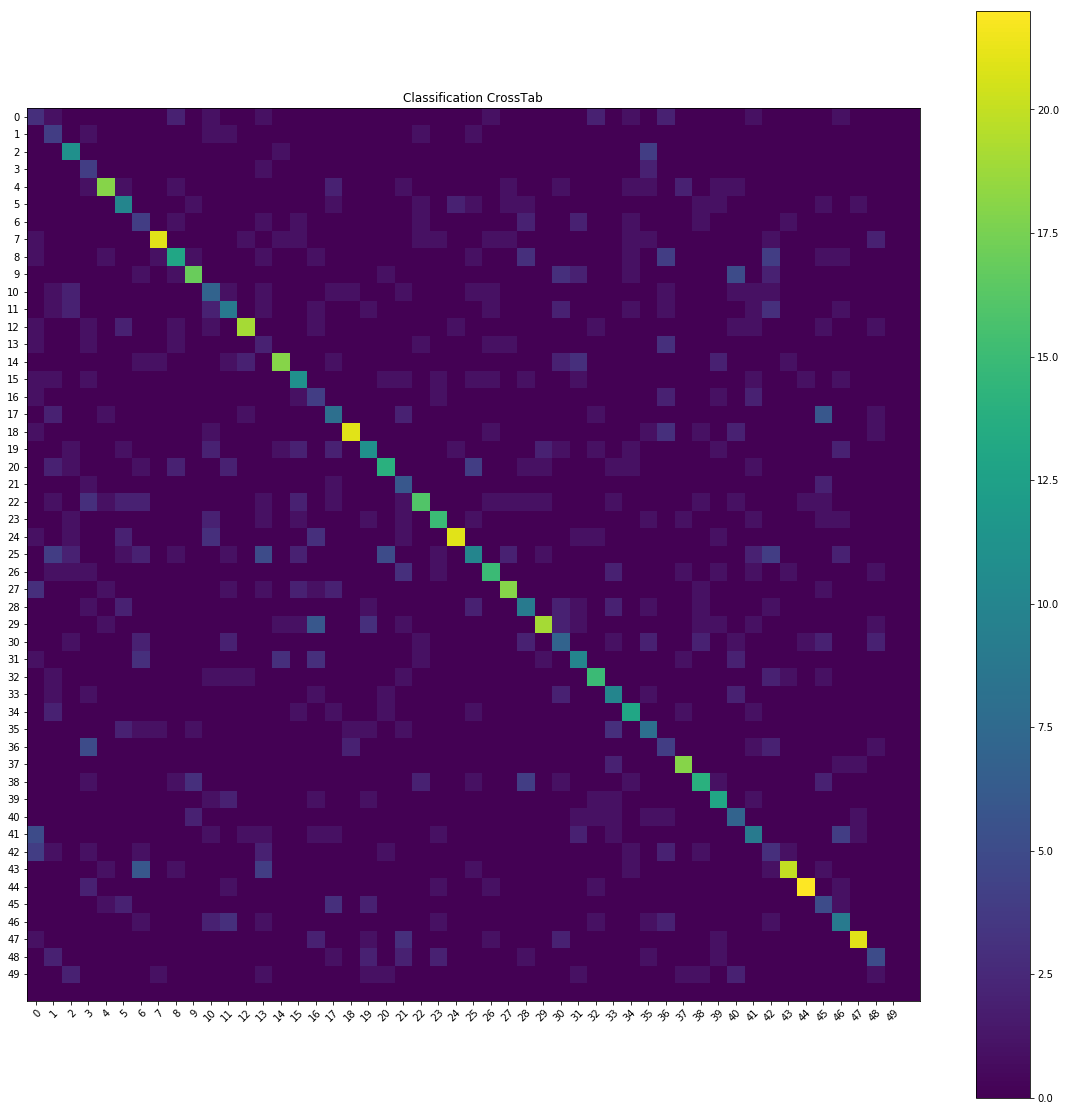

In [11]:
# evaluate
test_config = {}
test_config['test_datagen'] = train_config['test_datagen']
test_config['metrics']      = train_config['metrics']
test_config['devices']      = train_config['devices']
test_config['loss_fcn']     = train_config['loss_fcn']

for metric in test_config['metrics']:
    metric.reset()
test_loss, test_accuracies, cross_tab = evaluate(landmark_cnn, test_config)

# show results
print(f"Test\n Loss: {test_loss}\n{test_accuracies}")

plt.figure(figsize=(20, 20))

axis_labels = [f"{i}" for i in range(N_OUTPUT_CLASSES)]#[s for s in test_dataset.synsets]
ax = plt.gca()
im = ax.imshow(cross_tab)
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(range(0, N_OUTPUT_CLASSES))
ax.set_yticks(range(0, N_OUTPUT_CLASSES))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.title("Classification CrossTab", fontsize=12)
plt.show()

## Weight Initialization Test


In [ ]:
init_new = init.Normal(sigma=0.2)
landmark_cnn_new = landmark_cnn[:]
landmark_cnn_new.initialize(init=init_new, force_reinit=True, ctx=ctx)
landmark_cnn_new.hybridize()
landmark_cnn_new

### Train with new initialization

In [ ]:
# setup
train_config_new = train_config
train_config_new['trainer'] = gluon.Trainer(landmark_cnn_new.collect_params(),
                                            optimizer=train_config_new['optimizer'])

In [ ]:
for epoch in range(2):
    print(f"Epoch {epoch}")

    train_loss, train_log = train_loop_one_epoch(landmark_cnn_new, train_config_new)
    valid_loss, valid_log = validation_loop_one_epoch(landmark_cnn_new, train_config_new)

**Training Log output**

```
Epoch 0
train | (60/61): loss: 3.87712, accuracy: 0.08282, top_k_accuracy_3: 0.16005
valid | loss: 3.66212, accuracy: 0.11426, top_k_accuracy_3: 0.23633
Epoch 1
train | (61/62): loss: 3.64604, accuracy: 0.11700, top_k_accuracy_3: 0.22341
valid | loss: 3.25397, accuracy: 0.19141, top_k_accuracy_3: 0.31738
Epoch 2
train | (61/62): loss: 3.48943, accuracy: 0.14737, top_k_accuracy_3: 0.27262
valid | loss: 3.55357, accuracy: 0.21415, top_k_accuracy_3: 0.36305
Epoch 3
train | (60/61): loss: 3.48995, accuracy: 0.17841, top_k_accuracy_3: 0.31058
valid | loss: 3.23983, accuracy: 0.24121, top_k_accuracy_3: 0.37402
Epoch 4
train | (61/62): loss: 3.34187, accuracy: 0.20161, top_k_accuracy_3: 0.34621
valid | loss: 2.93397, accuracy: 0.25195, top_k_accuracy_3: 0.40820
Epoch 5
train | (61/62): loss: 3.33749, accuracy: 0.22455, top_k_accuracy_3: 0.37714
valid | loss: 3.28899, accuracy: 0.26103, top_k_accuracy_3: 0.40533
Epoch 6
train | (60/61): loss: 3.13213, accuracy: 0.24328, top_k_accuracy_3: 0.39581
valid | loss: 2.78515, accuracy: 0.29785, top_k_accuracy_3: 0.45605
```

## Transfer Learning

Out of all pre-trained models, I chose [MobileNetV2](https://arxiv.org/pdf/1801.04381.pdf) as the parameter count is much closer to the model I designed but the architecture is quite different. Hence, I am curious to see how well it will be able to handle current problem.

- [Pre-trained Model References](https://towardsdatascience.com/4-pre-trained-cnn-models-to-use-for-computer-vision-with-transfer-learning-885cb1b2dfc)
- [Mxnet-ModelZoo](https://mxnet.apache.org/api/python/docs/api/gluon/model_zoo/index.html)
- [Depthwise Separable Convolutions-1](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728)
- [Depthwise Separable Convolutions-2](https://eli.thegreenplace.net/2018/depthwise-separable-convolutions-for-machine-learning/)
- [MobileNetV2 details](https://medium.com/@luis_gonzales/a-look-at-mobilenetv2-inverted-residuals-and-linear-bottlenecks-d49f85c12423)
- [Residual, BottleNeck, Inverted Residual, Linear BottleNeck](https://towardsdatascience.com/residual-bottleneck-inverted-residual-linear-bottleneck-mbconv-explained-89d7b7e7c6bc)

In [11]:
from mxnet.gluon.model_zoo import vision

In [12]:
#setup pretrained model
mobilenetv2 = vision.mobilenet_v2_1_0(pretrained=True, ctx=ctx)

# add top layer
mobilenetv2.output.add(nn.Dense(units=500), nn.BatchNorm())
mobilenetv2.output[-2:].initialize(init=init.Xavier(), ctx=ctx)

mobilenetv2.output.add(nn.Activation('relu'), nn.Dropout(0.2))

mobilenetv2.output.add(nn.Dense(units=50))
mobilenetv2.output[-1].initialize(init=init.Xavier(), ctx=ctx)


########## LOAD ALREADY TRAINED PARAMETERS ###############################################
mobilenetv2.load_parameters('model_ckpts/model_ckpt_04-06-2022_22-02-28.params', ctx=ctx)

# collect trainable parameters
mobilenetv2_trainable_params = mobilenetv2.collect_params()

# summarize network
mobilenetv2.summary(dummy_input)
mobilenetv2.hybridize()

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                           (64, 3, 256, 256)               0
            Conv2D-1                          (64, 32, 128, 128)             864
         BatchNorm-2                          (64, 32, 128, 128)             128
             RELU6-3                          (64, 32, 128, 128)               0
            Conv2D-4                          (64, 32, 128, 128)            1024
         BatchNorm-5                          (64, 32, 128, 128)             128
             RELU6-6                          (64, 32, 128, 128)               0
            Conv2D-7                          (64, 32, 128, 128)             288
         BatchNorm-8                          (64, 32, 128, 128)             128
             RELU6-9                          (64, 32, 128, 128)               0
           Conv2D-10        

In [13]:
# setup trainer
model_ckpt(mobilenetv2)

# define loss and metrics for the training loop
mobilenet_train_config = {}
mobilenet_train_config['optimizer'] = mx.optimizer.Adam(learning_rate=1e-3, wd=0.000001) # weight decay -> L2-regularization
mobilenet_train_config['metrics']   = [mx.metric.Accuracy(), mx.metric.TopKAccuracy(top_k=3)]
mobilenet_train_config['loss_fcn']  = gluon.loss.SoftmaxCrossEntropyLoss(from_logits=False, sparse_label=True)
mobilenet_train_config['trainer']   = gluon.Trainer(mobilenetv2_trainable_params, optimizer=mobilenet_train_config['optimizer'])
mobilenet_train_config['devices']   = [ctx]
mobilenet_train_config['model_ckpt_freq'] = 1 # for every n epochs ckpt model

mobilenet_train_config['batch_size'] = 64
mobilenet_train_config['batch_aug']  = False
mobilenet_train_config['valid_frac'] = 0.2
mobilenet_train_config['last_batch'] = 'rollover'

train_datagen, valid_datagen, test_datagen = generate_datasets(TRAIN_FOLDER, 
                                                               TEST_FOLDER, 
                                                               mobilenet_train_config)
mobilenet_train_config['train_datagen'] = train_datagen
mobilenet_train_config['valid_datagen'] = valid_datagen
mobilenet_train_config['test_datagen']  = test_datagen

In [ ]:
# perform training
for epoch in range(1):
    print(f"Epoch {epoch}")

    train_loss, train_log = train_loop_one_epoch(mobilenetv2, mobilenet_train_config)
    valid_loss, valid_log = validation_loop_one_epoch(mobilenetv2, mobilenet_train_config)

    if (( (epoch+1) % mobilenet_train_config['model_ckpt_freq']) == 0):
        params_ckpt(mobilenetv2, epoch, train_loss, train_log, valid_loss, valid_log)

**Transfer Learning Training Log**

```
loss: 1.77507, accuracy: 0.42008, top_k_accuracy_3: 0.58171 --------> Freezed Conv Layers, Train Final Dense Layers
valid | loss: 1.56214, accuracy: 0.60352, top_k_accuracy_3: 0.75684
model_ckpts/model_ckpt_04-06-2022_21-33-27.params
-------------------
loss: 1.18948, accuracy: 0.62878, top_k_accuracy_3: 0.78881 --------> Freezed Conv Layers, Train Final Dense Layers
valid | loss: 1.32506, accuracy: 0.63672, top_k_accuracy_3: 0.77344
model_ckpts/model_ckpt_04-06-2022_21-35-19.params
-------------------
loss: 1.16967, accuracy: 0.68221, top_k_accuracy_3: 0.82686 --------> Freezed Conv Layers, Train Final Dense Layers
valid | loss: 1.30251, accuracy: 0.68474, top_k_accuracy_3: 0.81342
model_ckpts/model_ckpt_04-06-2022_21-37-04.params
-------------------
loss: 1.13735, accuracy: 0.71183, top_k_accuracy_3: 0.85297 --------> Freezed Conv Layers, Train Final Dense Layers
valid | loss: 1.19720, accuracy: 0.68750, top_k_accuracy_3: 0.82129
model_ckpts/model_ckpt_04-06-2022_21-39-07.params
-------------------
loss: 1.02352, accuracy: 0.74849, top_k_accuracy_3: 0.87147 --------> Freezed Conv Layers, Train Final Dense Layers
valid | loss: 1.08014, accuracy: 0.68848, top_k_accuracy_3: 0.82617
model_ckpts/model_ckpt_04-06-2022_21-41-10.params
-------------------
loss: 1.67483, accuracy: 0.50026, top_k_accuracy_3: 0.68494 --------> Train Conv Layers, Train Final Dense Layers
valid | loss: 1.80864, accuracy: 0.54395, top_k_accuracy_3: 0.70605
model_ckpts/model_ckpt_04-06-2022_21-47-07.params
-------------------
loss: 1.35442, accuracy: 0.60081, top_k_accuracy_3: 0.76764 --------> Train Conv Layers, Train Final Dense Layers
valid | loss: 1.57531, accuracy: 0.56055, top_k_accuracy_3: 0.73242
model_ckpts/model_ckpt_04-06-2022_21-49-05.params
-------------------
loss: 1.10537, accuracy: 0.64667, top_k_accuracy_3: 0.80670 --------> Train Conv Layers, Train Final Dense Layers
valid | loss: 1.58002, accuracy: 0.60662, top_k_accuracy_3: 0.78493
model_ckpts/model_ckpt_04-06-2022_21-50-43.params
-------------------
loss: 1.10785, accuracy: 0.68058, top_k_accuracy_3: 0.83478 --------> Train Conv Layers, Train Final Dense Layers
valid | loss: 1.42574, accuracy: 0.63574, top_k_accuracy_3: 0.79590
model_ckpts/model_ckpt_04-06-2022_21-52-20.params
-------------------
loss: 1.12698, accuracy: 0.69556, top_k_accuracy_3: 0.83518 --------> Train Conv Layers, Train Final Dense Layers
valid | loss: 1.41816, accuracy: 0.63477, top_k_accuracy_3: 0.77344
model_ckpts/model_ckpt_04-06-2022_21-54-03.params
-------------------
loss: 0.69484, accuracy: 0.77394, top_k_accuracy_3: 0.89768 --------> Train Conv Layers, Train Final Dense Layers
valid | loss: 1.14930, accuracy: 0.70772, top_k_accuracy_3: 0.84651
model_ckpts/model_ckpt_04-06-2022_21-55-50.params
-------------------
loss: 0.53942, accuracy: 0.82659, top_k_accuracy_3: 0.92264 --------> Train Conv Layers, Train Final Dense Layers
valid | loss: 0.97534, accuracy: 0.71875, top_k_accuracy_3: 0.84863
model_ckpts/model_ckpt_04-06-2022_21-58-41.params
-------------------
loss: 0.54136, accuracy: 0.84199, top_k_accuracy_3: 0.92792 --------> Train Conv Layers, Train Final Dense Layers
valid | loss: 1.05582, accuracy: 0.74081, top_k_accuracy_3: 0.85846
model_ckpts/model_ckpt_04-06-2022_22-00-28.params
-------------------
loss: 0.37884, accuracy: 0.85030, top_k_accuracy_3: 0.93700 --------> Train Conv Layers, Train Final Dense Layers
valid | loss: 0.97149, accuracy: 0.74707, top_k_accuracy_3: 0.86816
model_ckpts/model_ckpt_04-06-2022_22-02-28.params           --------> Select this as a Best Fit
-------------------
```

## Evaluation

Test
 Loss: 0.6526021227240563
{'accuracy': 0.821546052631579, 'top_k_accuracy_3': 0.9194078947368421}


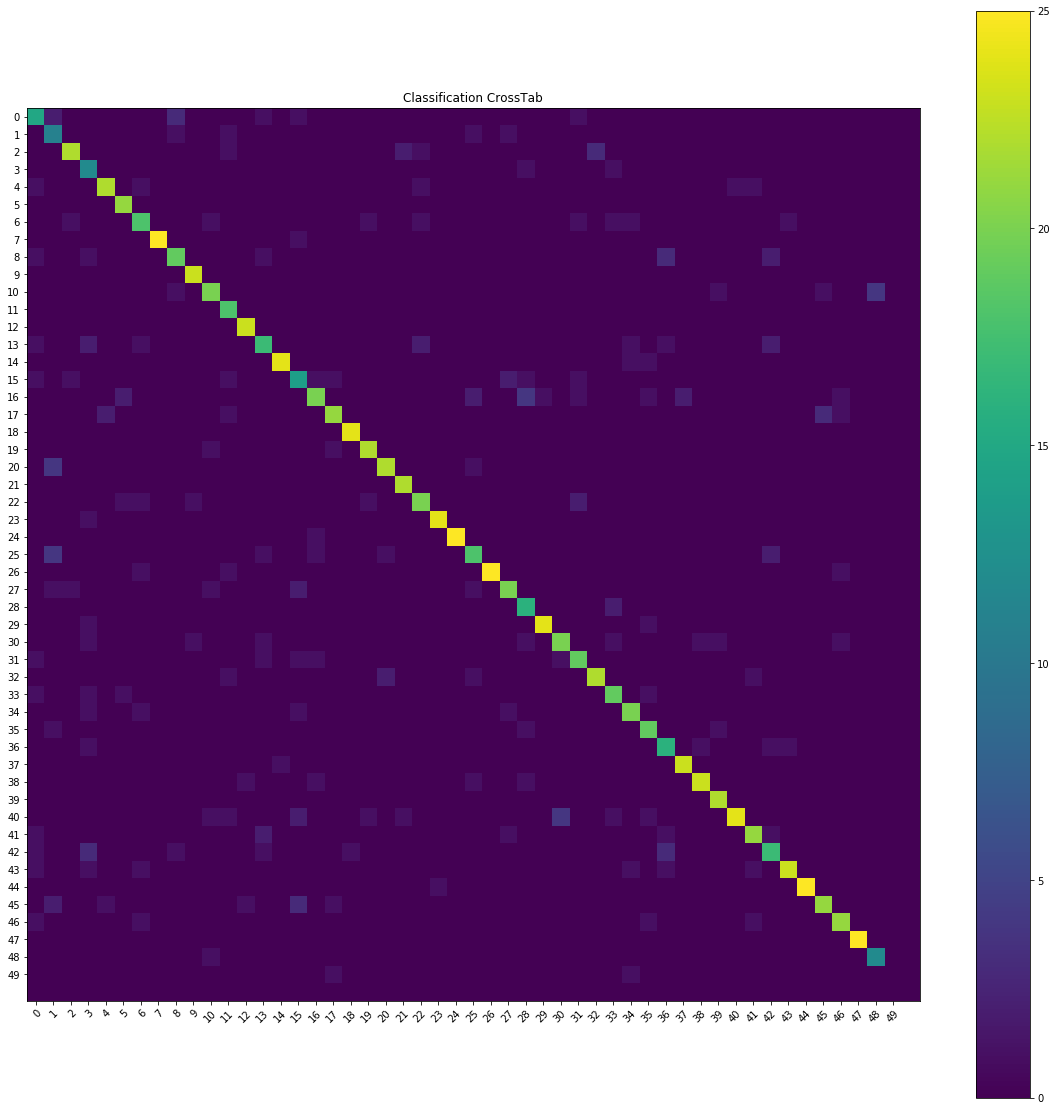

In [15]:
# evaluate
test_config = {}
test_config['test_datagen'] = mobilenet_train_config['test_datagen']
test_config['metrics']      = mobilenet_train_config['metrics']
test_config['devices']      = mobilenet_train_config['devices']
test_config['loss_fcn']     = mobilenet_train_config['loss_fcn']

for metric in test_config['metrics']:
    metric.reset()
test_loss, test_accuracies, cross_tab = evaluate(mobilenetv2, test_config)

# show results
print(f"Test\n Loss: {test_loss}\n{test_accuracies}")

plt.figure(figsize=(20, 20))

axis_labels = [f"{i}" for i in range(N_OUTPUT_CLASSES)]#[s for s in test_dataset.synsets]
ax = plt.gca()
im = ax.imshow(cross_tab)
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(range(0, N_OUTPUT_CLASSES))
ax.set_yticks(range(0, N_OUTPUT_CLASSES))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.title("Classification CrossTab", fontsize=12)
plt.show()

## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [14]:
from matplotlib import image

# load dataset again to get class names
test_dataset = datasets.ImageFolderDataset(TEST_FOLDER, 1)
classes = np.array(test_dataset.synsets)
img_transforms = transforms.Compose(INITIAL_TRANSFORMATIONS)

def predict_landmarks(img_path, k):
    # load image
    img = image.imread(img_path)

    # transform it into required size for the network
    nd_img = nd.array(img, ctx=ctx)
    nd_img = nd.expand_dims(nd_img, axis=0)

    input_transformed = img_transforms(nd_img)

    # predict
    y_predict = mobilenetv2(input_transformed)
    y_predict_sftmx = nd.SoftmaxActivation(y_predict)

    # extract top_k classes
    a = y_predict_sftmx.asnumpy().ravel()
    top_k_indices = np.argpartition(a, -k)[-k:]
    top_k_indices = top_k_indices[np.argsort(-a[top_k_indices])]

    # process classes and output them
    top_k_classes = list(classes[top_k_indices])
    top_k_classes = [top_k.split('.')[-1] for top_k in top_k_classes]
    return top_k_classes

# test on a sample image
predict_landmarks('landmark_images/test/19.Vienna_City_Hall/3a208e808372be44.jpg', 5)

['Vienna_City_Hall',
 'Whitby_Abbey',
 'Brooklyn_Bridge',
 'Gateway_of_India',
 'Edinburgh_Castle']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

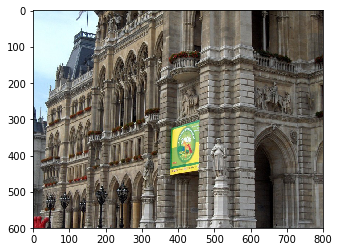

['Vienna_City_Hall', 'Whitby_Abbey', 'Brooklyn_Bridge']


In [15]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)

    # show image
    img = image.imread(img_path)
    plt.figure()
    plt.imshow(img)
    plt.show()

    print(predicted_landmarks)

# test on a sample image
suggest_locations('landmark_images/test/19.Vienna_City_Hall/3a208e808372be44.jpg')

### Custom Images Test

Image:  cathedralRock_sedona_arizona.jpg


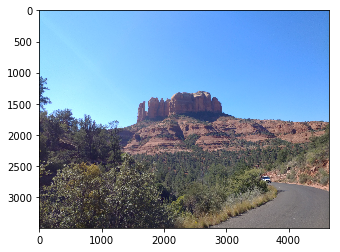

['Grand_Canyon', 'Delicate_Arch', 'Machu_Picchu']




Image:  overlook2_yosemite_california.jpg


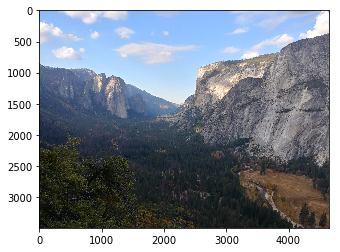

['Great_Wall_of_China', 'Banff_National_Park', 'Yellowstone_National_Park']




Image:  deathValley_nevada.jpg


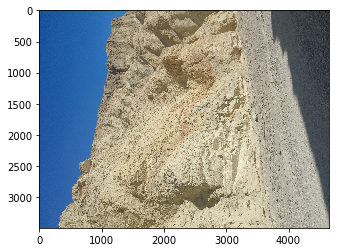

['Washington_Monument', 'Mount_Rushmore_National_Memorial', 'Dead_Sea']




Image:  route89Valley_sedona_arizona.jpg


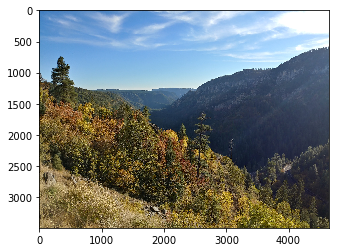

['Machu_Picchu', 'Banff_National_Park', 'Yellowstone_National_Park']




Image:  grandCanyon_tontoWest_arizona.jpg


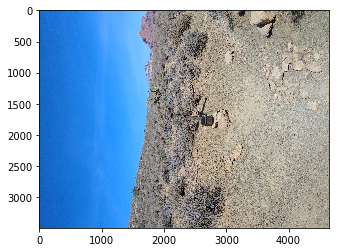

['Washington_Monument', 'Stockholm_City_Hall', 'Death_Valley_National_Park']




Image:  grandCanyon_mules_arizona.jpg


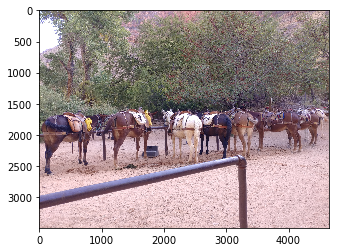

['Dead_Sea', 'Death_Valley_National_Park', 'Mount_Rushmore_National_Memorial']




Image:  basin_deathValley_nevada.jpg


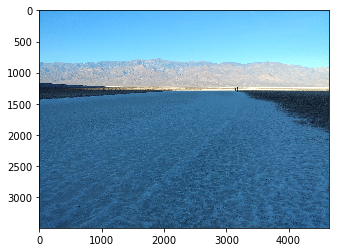

['Dead_Sea', 'Great_Barrier_Reef', 'Death_Valley_National_Park']




Image:  yosemiteFalls_yosemite_california.jpg


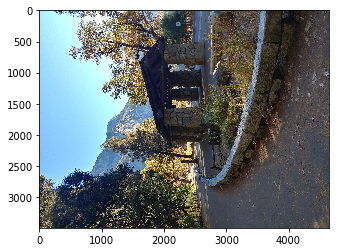

['Eiffel_Tower', 'Edinburgh_Castle', 'Central_Park']




Image:  sandDunes_deathValley_nevada.jpg


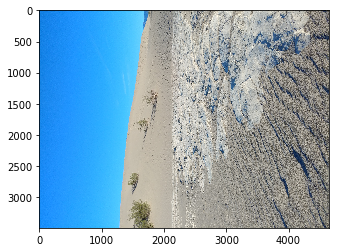

['Washington_Monument', 'Eiffel_Tower', 'Stockholm_City_Hall']




Image:  grandCanyon_arizona.jpg


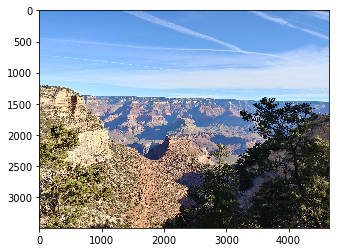

['Grand_Canyon', 'Death_Valley_National_Park', 'Banff_National_Park']




Image:  overlook3_yosemite_california.jpg


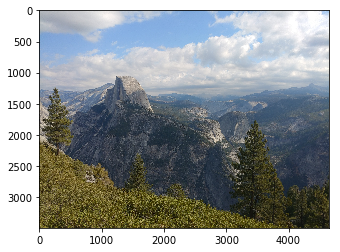

['Banff_National_Park', 'Machu_Picchu', 'Matterhorn']




Image:  desertTower_grandCanyon_arizona.jpg


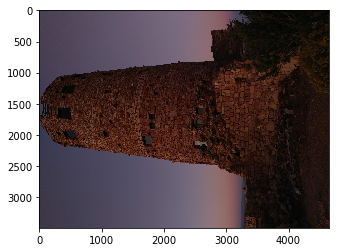

['Ljubljana_Castle', 'Grand_Canyon', 'Kantanagar_Temple']




Image:  sedona_arizona.jpg


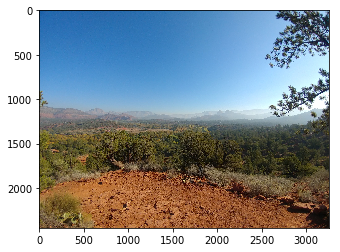

['Grand_Canyon', 'Haleakala_National_Park', 'Yellowstone_National_Park']




Image:  overlook1_yosemite_california.jpg


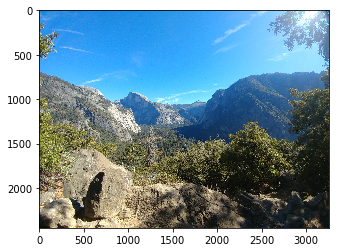

['Machu_Picchu', 'Grand_Canyon', 'Mount_Rushmore_National_Memorial']






In [17]:
import glob
custom_images = glob.glob("custom_images/*.jpg")

for custom_image in custom_images:
    print("Image: ", custom_image.split('/')[-1])
    suggest_locations(custom_image)
    print('\n\n\n')
